# Telco Customer Churn - Full Analysis and Model Building

This notebook presents a detailed end-to-end analysis of the Telco Customer Churn dataset sourced from OpenML. The primary objective is to develop predictive models capable of identifying customers likely to churn, thereby supporting strategic retention efforts.

The workflow begins with data loading and exploration, followed by treatment of missing values and extensive exploratory data analysis (EDA). Key patterns are visualized to understand the relationship between churn and customer demographics, service types, billing preferences, and contract terms. Feature encoding and scaling are performed to prepare the dataset for machine learning algorithms.

Three supervised classification models:- Decision Tree, Random Forest, and Logistic Regression are trained and evaluated first on the original imbalanced data. Due to the skewed target distribution (~73% non-churn, ~27% churn), performance is then re-evaluated after applying SMOTEENN, a hybrid resampling technique that improves class balance. Model performance is assessed using accuracy, precision, recall, and F1-score, with an emphasis on the minority (churn) class.


## 1. Importing necessary libraries

In [1]:
import arff
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from imblearn.combine import SMOTEENN
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


## 2. Data Loading and Initial Exploration

In [2]:
# Load the ARFF file
with open('telco_customer_churn.arff', 'r') as file:
    data = arff.load(file)

# Convert to DataFrame
df = pd.DataFrame(data['data'], columns=[attr[0] for attr in data['attributes']])

# Display the first few rows
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
# Checking shape of the dataset
df.shape

(7043, 20)

In [4]:
# Checking basic information about the dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   object 
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null   object 


In [5]:
# Check the descriptive statistics of numeric variables
df.describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


## 3. Missing Value Analysis and Treatment

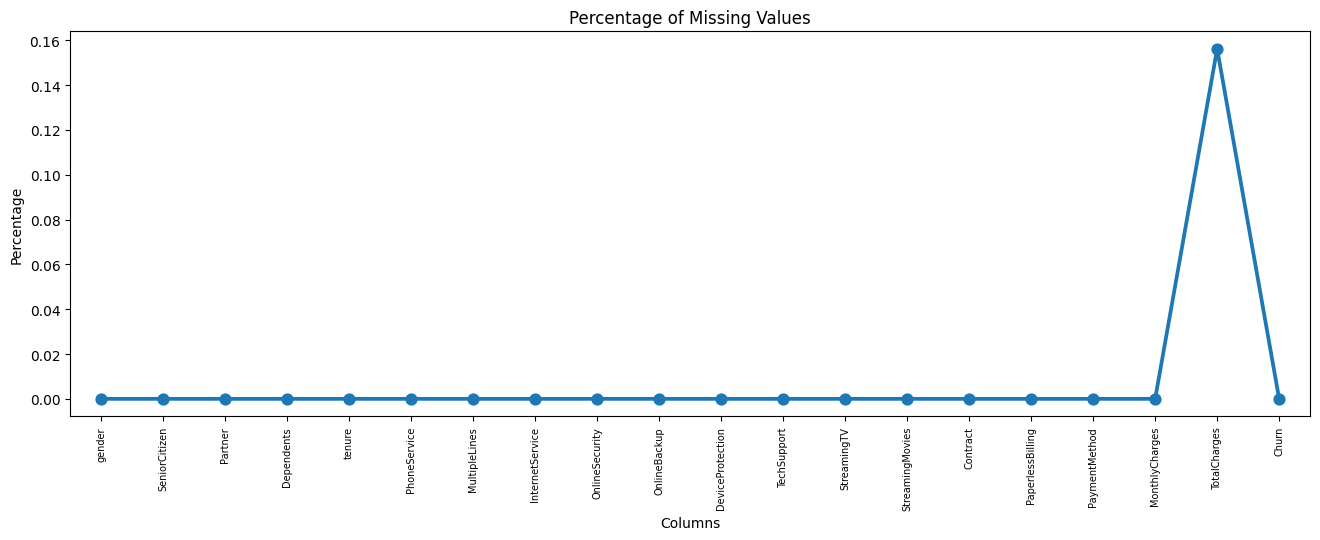

In [6]:
# Calculate percentage of missing values for each column
missing = pd.DataFrame((df.isnull().sum()) * 100 / df.shape[0]).reset_index()
missing.columns = ['Column', 'MissingPercentage']

# Plot missing value percentage
plt.figure(figsize=(16, 5))
sns.pointplot(x='Column', y='MissingPercentage', data=missing)
plt.xticks(rotation=90, fontsize=7)
plt.title("Percentage of Missing Values")
plt.xlabel("Columns")
plt.ylabel("Percentage")
plt.show()

#### Observation:
A missing value heatmap is generated to visually assess the presence and proportion of missing data across columns. Key treatment:

- Only the `TotalCharges` column has missing values (~0.15% of the dataset).
- These values are treated using `pd.to_numeric` with coercion, replacing `NaN` with 0 due to their insignificant proportion.


In [7]:
print(df.isnull().sum())

gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64


## 4. Data Cleaning

As we can see there are 11 missing values in TotalCharges column. Let's check these records

In [8]:
df.loc[df ['TotalCharges'].isnull() == True]

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
488,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,No,Yes,Yes,Yes,No,Two year,Yes,Bank transfer (automatic),52.55,NaN,No
753,Male,0,No,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.25,NaN,No
936,Female,0,Yes,Yes,0,Yes,No,DSL,Yes,Yes,Yes,No,Yes,Yes,Two year,No,Mailed check,80.85,NaN,No
1082,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.75,NaN,No
1340,Female,0,Yes,Yes,0,No,No phone service,DSL,Yes,Yes,Yes,Yes,Yes,No,Two year,No,Credit card (automatic),56.05,NaN,No
3331,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,19.85,NaN,No
3826,Male,0,Yes,Yes,0,Yes,Yes,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,25.35,NaN,No
4380,Female,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,No,Mailed check,20.00,NaN,No
5218,Male,0,Yes,Yes,0,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,One year,Yes,Mailed check,19.70,NaN,No
6670,Female,0,Yes,Yes,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Two year,No,Mailed check,73.35,NaN,No


- Since the % of these records compared to total dataset is very low ie 0.15%, it is safe to ignore them from further processing.

In [9]:
# Treat TotalCharges: Convert to numeric and fill missing values with 0
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce').fillna(0)

In [10]:
# Re-check for any remaining missing values
print(df.isnull().sum())

gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


## 5. Target Variable Exploration

In [11]:
# Checking the distribution of the target variable (Churn)
df['Churn'].value_counts()


Churn
No     5174
Yes    1869
Name: count, dtype: int64

In [12]:
100*df['Churn'].value_counts()/len(df['Churn'])

Churn
No     73.463013
Yes    26.536987
Name: count, dtype: float64

- Data is highly imbalanced, ratio = 73:27
- So we analyse the data with other features while taking the target values separately to get some insights.

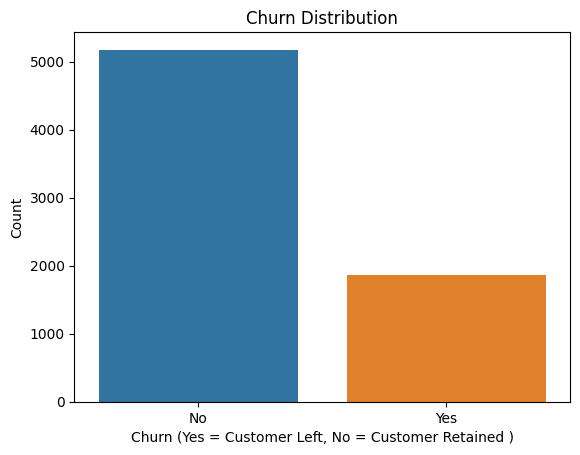

In [13]:
# Visualizing the target variable
sns.countplot(x='Churn', hue='Churn',data=df)
plt.title('Churn Distribution')
plt.xlabel('Churn (Yes = Customer Left, No = Customer Retained )')
plt.ylabel('Count')
plt.show()


#### Observation: Class Imbalance in Target Variable

The target variable `Churn` is imbalanced, with ~73% "No" and ~27% "Yes". This imbalance necessitates resampling (e.g., SMOTEENN) to improve model sensitivity to minority class predictions.



## 6. Exploratory Data Analysis:

### 6.1 Distribution plots for numerical features

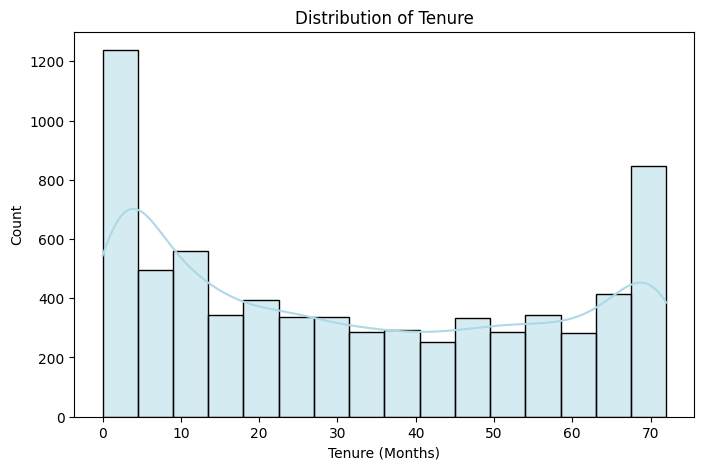

In [14]:
# tenure
plt.figure(figsize=(8, 5))
sns.histplot(df['tenure'], kde=True, color='lightblue')
plt.title('Distribution of Tenure')
plt.xlabel('Tenure (Months)')
plt.ylabel('Count')
plt.show()

#### Observation:

Tenure shows a U-shaped distribution. Most customers either churn early or stay long-term. This indicates `tenure` is a strong negative predictor of churn.


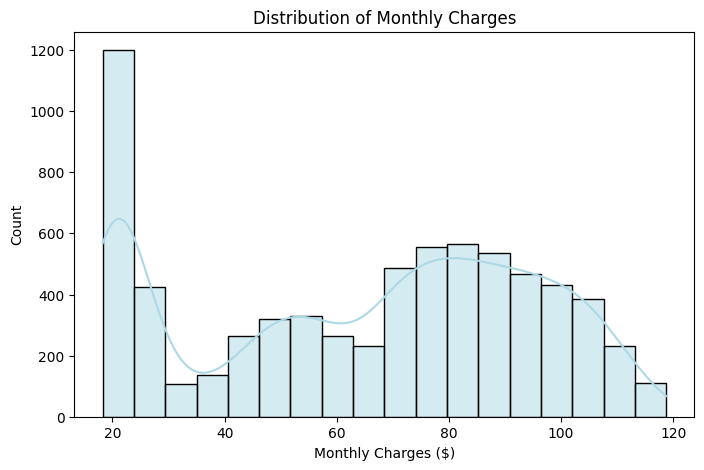

In [15]:
# MonthlyCharges
plt.figure(figsize=(8, 5))
sns.histplot(df['MonthlyCharges'], kde=True, color='lightblue')
plt.title('Distribution of Monthly Charges')
plt.xlabel('Monthly Charges ($)')
plt.ylabel('Count')
plt.show()

#### Observation:
`MonthlyCharges` is right-skewed. Churners tend to fall in higher monthly charge ranges, indicating price sensitivity and potential dissatisfaction.


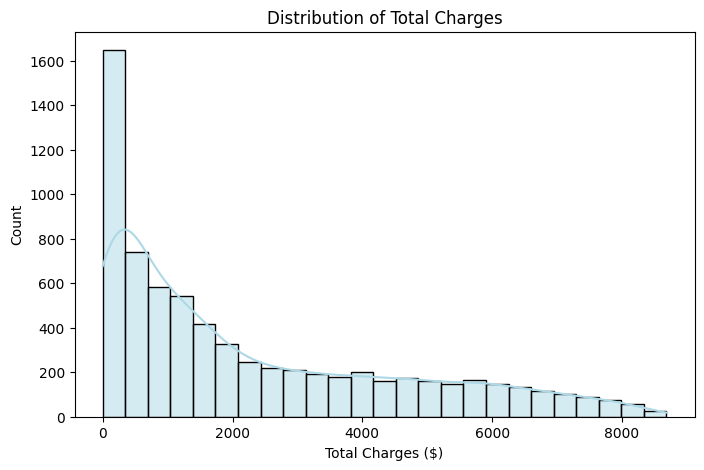

In [16]:
# TotalCharges
plt.figure(figsize=(8, 5))
sns.histplot(df['TotalCharges'], kde=True, color='lightblue')
plt.title('Distribution of Total Charges')
plt.xlabel('Total Charges ($)')
plt.ylabel('Count')
plt.show()

#### Observation:
`TotalCharges` is highly right-skewed. Lower charges associate with churn due to short tenure. High charges align with customer loyalty.


### 6.2 Distribution plots for categorical features
 - We'll plot each feature split by Churn (Yes/No) to see differences.

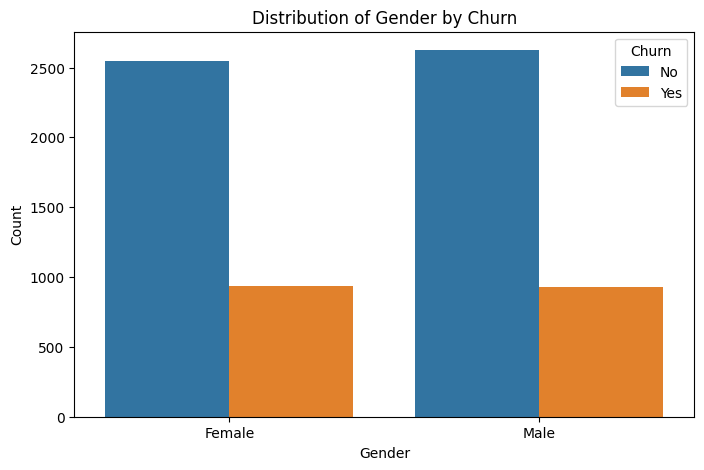

In [17]:
# gender
plt.figure(figsize=(8, 5))
sns.countplot(x='gender', hue='Churn', data=df)
plt.title('Distribution of Gender by Churn')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()

#### Observation:
Churn rates are similar across genders. Gender is not a useful predictor and likely exhibits negligible correlation with churn.


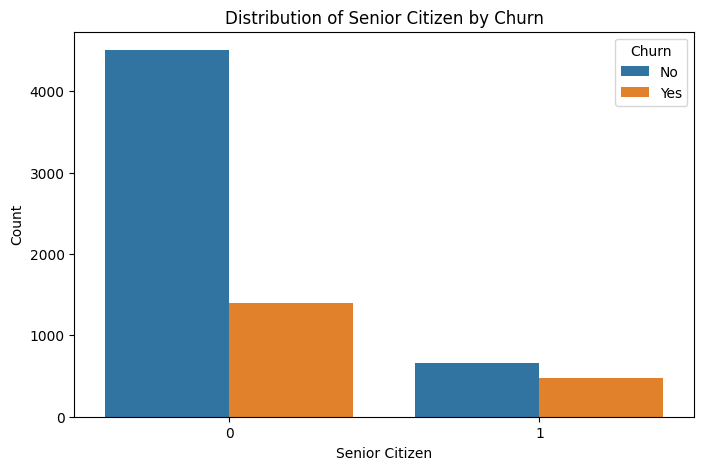

In [18]:
# SeniorCitizen
plt.figure(figsize=(8, 5))
sns.countplot(x='SeniorCitizen', hue='Churn', data=df)
plt.title('Distribution of Senior Citizen by Churn')
plt.xlabel('Senior Citizen')
plt.ylabel('Count')
plt.show()

#### Observation:
Senior citizens show higher churn rates, suggesting possible usability or affordability issues. This feature has moderate positive correlation with churn.


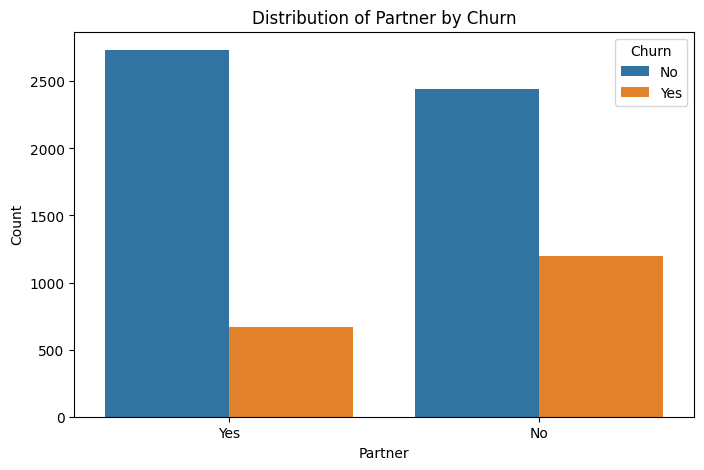

In [19]:
# Partner
plt.figure(figsize=(8, 5))
sns.countplot(x='Partner', hue='Churn', data=df)
plt.title('Distribution of Partner by Churn')
plt.xlabel('Partner')
plt.ylabel('Count')
plt.show()

#### Observation:
Customers with partners churn less, likely due to shared usage and higher service dependency. This is a useful negative predictor.


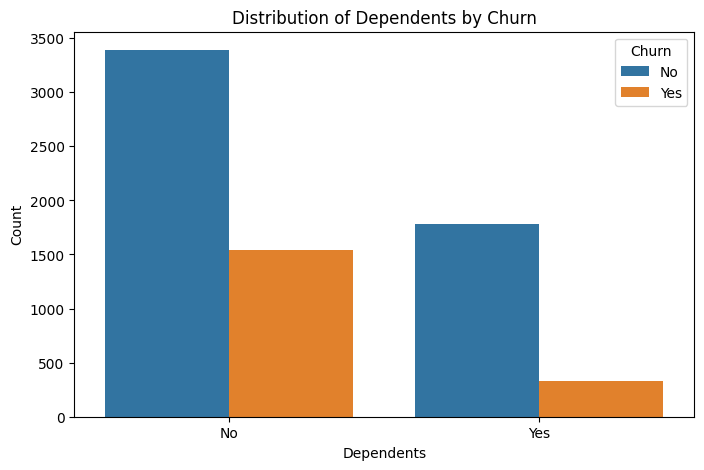

In [20]:
# Dependents
plt.figure(figsize=(8, 5))
sns.countplot(x='Dependents', hue='Churn', data=df)
plt.title('Distribution of Dependents by Churn')
plt.xlabel('Dependents')
plt.ylabel('Count')
plt.show()

#### Observation:
Having dependents is associated with lower churn, indicating bundled or family usage reduces churn risk.


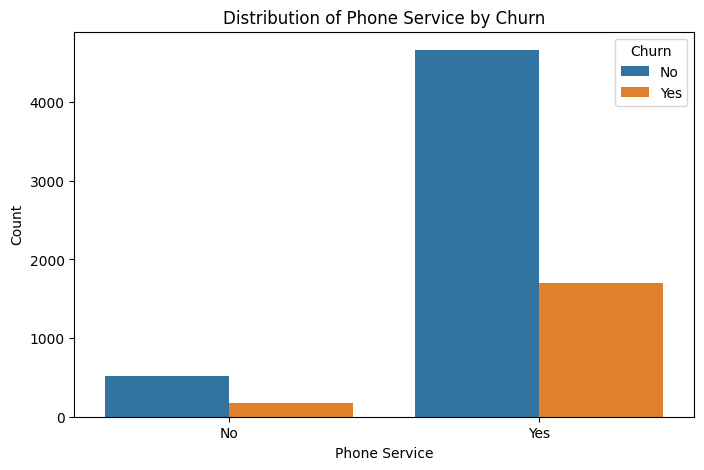

In [21]:
# PhoneService
plt.figure(figsize=(8, 5))
sns.countplot(x='PhoneService', hue='Churn', data=df)
plt.title('Distribution of Phone Service by Churn')
plt.xlabel('Phone Service')
plt.ylabel('Count')
plt.show()

#### Observation:
Phone service users churn more, possibly due to bundled packages or higher billing. Alone, this feature is weakly predictive.


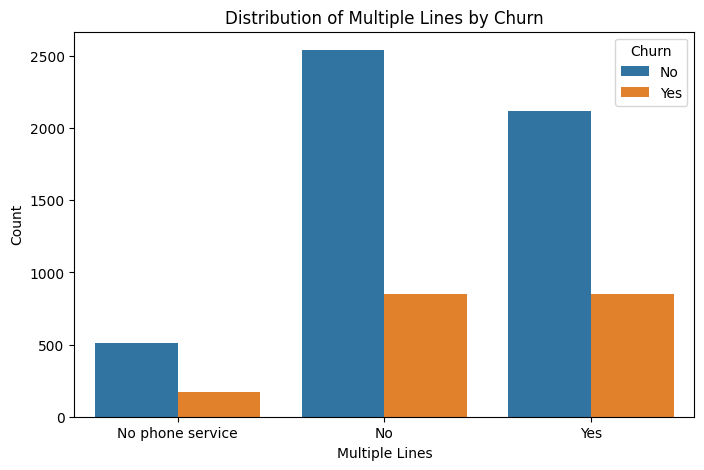

In [22]:
# MultipleLines
plt.figure(figsize=(8, 5))
sns.countplot(x='MultipleLines', hue='Churn', data=df)
plt.title('Distribution of Multiple Lines by Churn')
plt.xlabel('Multiple Lines')
plt.ylabel('Count')
plt.show()

#### Observation:
Customers with multiple lines show a slightly higher churn rate than those with a single line. However, churn is lowest among those with no phone service, indicating that bundling may contribute to churn behavior.


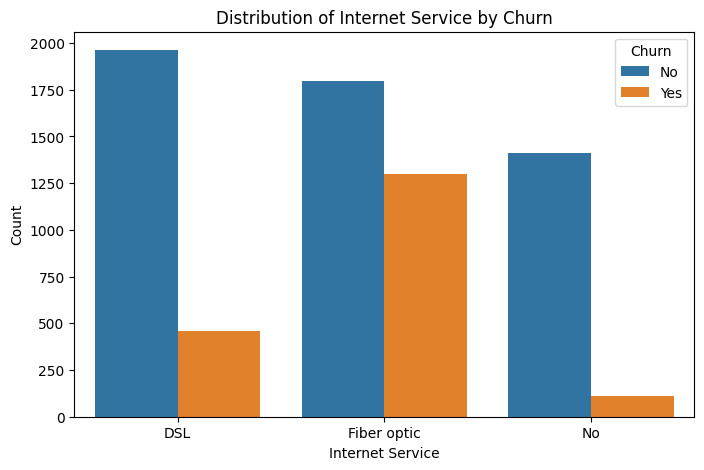

In [23]:
# InternetService
plt.figure(figsize=(8, 5))
sns.countplot(x='InternetService', hue='Churn', data=df)
plt.title('Distribution of Internet Service by Churn')
plt.xlabel('Internet Service')
plt.ylabel('Count')
plt.show()

#### Observation:
Churn is highest among fiber optic users, suggesting possible dissatisfaction with service quality or cost. Customers without internet service churn the least, likely due to limited engagement.


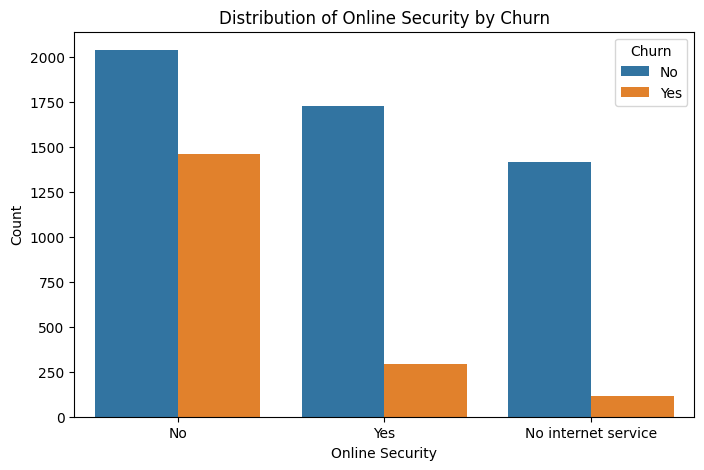

In [24]:
# OnlineSecurity
plt.figure(figsize=(8, 5))
sns.countplot(x='OnlineSecurity', hue='Churn', data=df)
plt.title('Distribution of Online Security by Churn')
plt.xlabel('Online Security')
plt.ylabel('Count')
plt.show()

#### Observation:
Customers without online security are significantly more likely to churn. Security services appear to enhance perceived value and reduce churn probability.


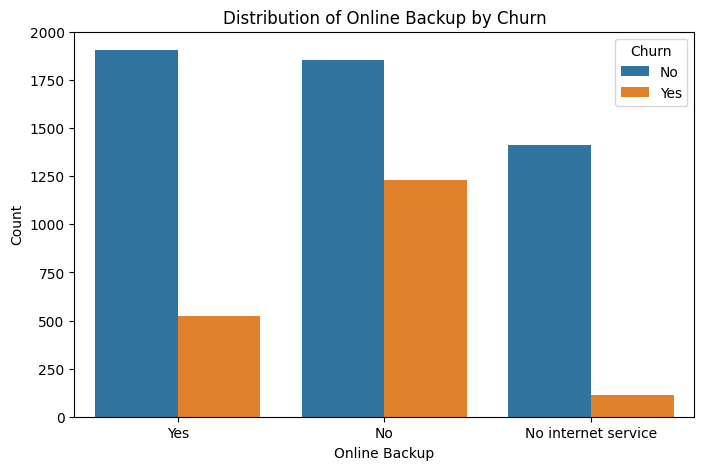

In [25]:
# OnlineBackup
plt.figure(figsize=(8, 5))
sns.countplot(x='OnlineBackup', hue='Churn', data=df)
plt.title('Distribution of Online Backup by Churn')
plt.xlabel('Online Backup')
plt.ylabel('Count')
plt.show()

#### Observation:
Churn is more prevalent among customers without online backup. The availability of backup services may contribute to greater retention.


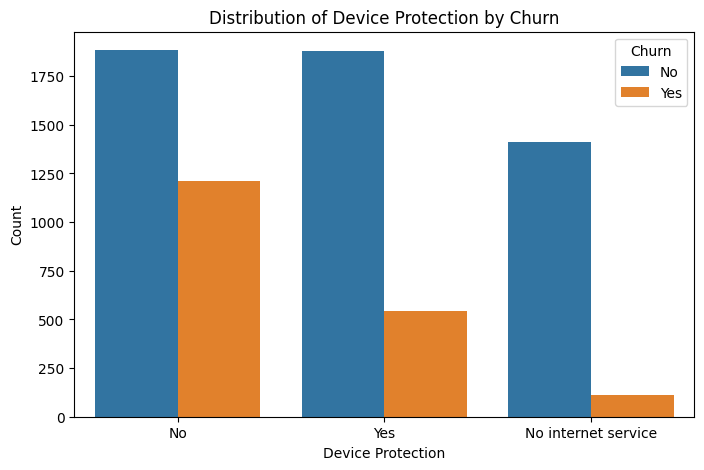

In [26]:
# DeviceProtection
plt.figure(figsize=(8, 5))
sns.countplot(x='DeviceProtection', hue='Churn', data=df)
plt.title('Distribution of Device Protection by Churn')
plt.xlabel('Device Protection')
plt.ylabel('Count')
plt.show()

#### Observation:
Customers without device protection show higher churn rates. This feature likely adds perceived reliability and helps retain users.


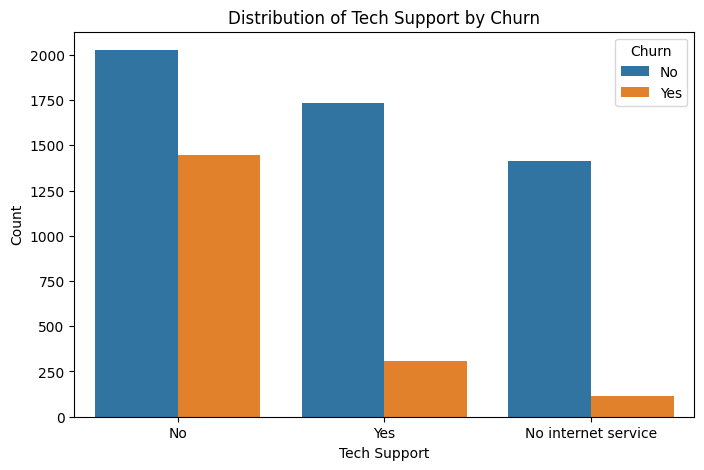

In [27]:
# TechSupport
plt.figure(figsize=(8, 5))
sns.countplot(x='TechSupport', hue='Churn', data=df)
plt.title('Distribution of Tech Support by Churn')
plt.xlabel('Tech Support')
plt.ylabel('Count')
plt.show()

#### Observation:

Churn is notably lower among customers with tech support. Absence of support services is strongly linked to churn, highlighting its retention value.


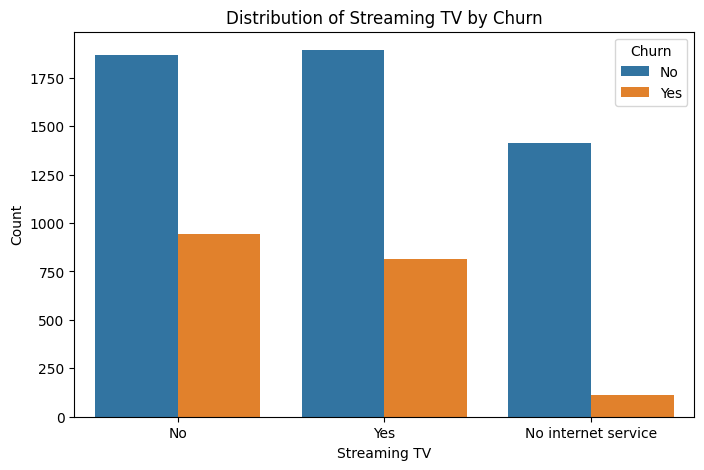

In [28]:
# StreamingTV
plt.figure(figsize=(8, 5))
sns.countplot(x='StreamingTV', hue='Churn', data=df)
plt.title('Distribution of Streaming TV by Churn')
plt.xlabel('Streaming TV')
plt.ylabel('Count')
plt.show()

#### Observation:
Churn is slightly higher among streaming TV users than non-users, possibly due to pricing or content dissatisfaction. Users without internet churn the least.


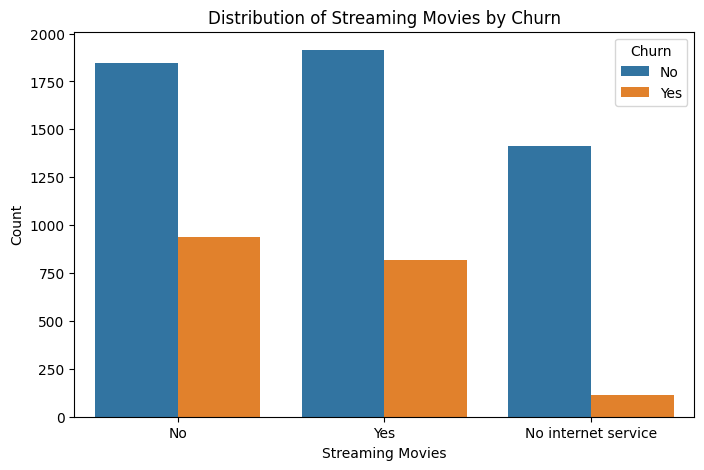

In [29]:
# StreamingMovies
plt.figure(figsize=(8, 5))
sns.countplot(x='StreamingMovies', hue='Churn', data=df)
plt.title('Distribution of Streaming Movies by Churn')
plt.xlabel('Streaming Movies')
plt.ylabel('Count')
plt.show()


#### Observation:
Similar to streaming TV, users with streaming movies also exhibit higher churn. Streaming services may increase churn risk if perceived as non-essential or overpriced.
`

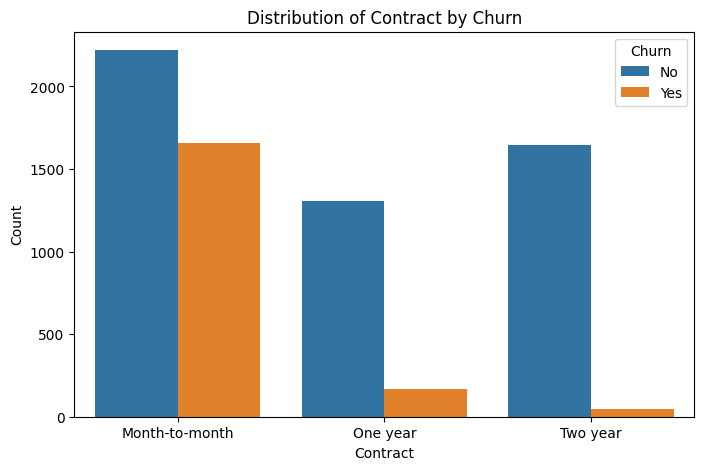

In [30]:
# Contract
plt.figure(figsize=(8, 5))
sns.countplot(x='Contract', hue='Churn', data=df)
plt.title('Distribution of Contract by Churn')
plt.xlabel('Contract')
plt.ylabel('Count')
plt.show()

#### Observation:
Churn is highest among month-to-month customers. One- and two-year contracts show much lower churn, confirming that longer contracts improve retention.


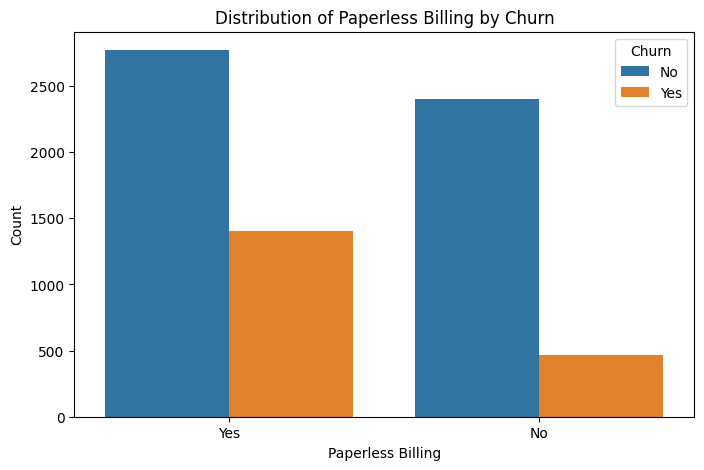

In [31]:
# PaperlessBilling
plt.figure(figsize=(8, 5))
sns.countplot(x='PaperlessBilling', hue='Churn', data=df)
plt.title('Distribution of Paperless Billing by Churn')
plt.xlabel('Paperless Billing')
plt.ylabel('Count')
plt.show()

#### Observation:
Customers with paperless billing churn more often. This may reflect a younger, tech-savvy demographic that is more price-sensitive or less loyal.


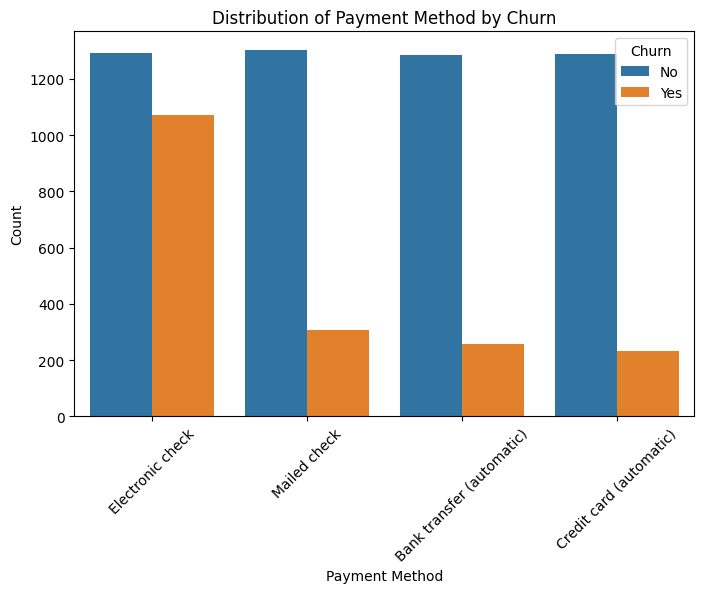

In [32]:
# PaymentMethod
plt.figure(figsize=(8, 5))
sns.countplot(x='PaymentMethod', hue='Churn', data=df)
plt.title('Distribution of Payment Method by Churn')
plt.xlabel('Payment Method')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#### Observation:
Customers paying via electronic check exhibit the highest churn rate among all payment methods. In contrast, churn is substantially lower for those using automatic methods like bank transfer or credit card, suggesting that automation supports retention by reducing effort or missed payments.


### 6.3 KDE Plots for Numerical Features by Churn

 **Convert the target variable 'Churn' in a binary numeric variable i.e. Yes=1 ; No = 0**

In [33]:
df['Churn'] = np.where(df.Churn == 'Yes',1,0)

In [34]:
df['Churn']

0       0
1       0
2       1
3       0
4       1
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: Churn, Length: 7043, dtype: int32

**Convert all the categorical variables into dummy variables**

In [35]:
telco_data_dummies = pd.get_dummies(df)
telco_data_dummies.head()

,tenure,MonthlyCharges,TotalCharges,Churn,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,...,StreamingMovies_Yes,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,1,29.85,29.85,0,True,False,True,False,False,True,...,False,True,False,False,False,True,False,False,True,False
1,34,56.95,1889.50,0,False,True,True,False,True,False,...,False,False,True,False,True,False,False,False,False,True
2,2,53.85,108.15,1,False,True,True,False,True,False,...,False,True,False,False,False,True,False,False,False,True
3,45,42.30,1840.75,0,False,True,True,False,True,False,...,False,False,True,False,True,False,True,False,False,False
4,2,70.70,151.65,1,True,False,True,False,True,False,...,False,True,False,False,False,True,False,False,True,False


**6.3.1 Monthly Charges vs. Churn (KDE Plot)**

Text(0.5, 1.0, 'Monthly charges by churn')

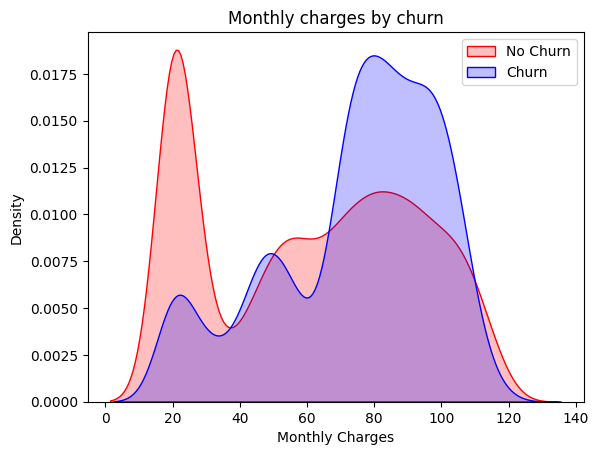

In [36]:
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 0) ],
                color="Red", fill = True)
Mth = sns.kdeplot(telco_data_dummies.MonthlyCharges[(telco_data_dummies["Churn"] == 1) ],
                ax =Mth, color="Blue", fill= True)
Mth.legend(["No Churn","Churn"],loc='upper right')
Mth.set_ylabel('Density')
Mth.set_xlabel('Monthly Charges')
Mth.set_title('Monthly charges by churn')


#### Observation:

- **Churned customers** (blue) are concentrated at **higher monthly charges** (~70–100), suggesting price sensitivity.
- **Non-churned customers** (red) peak at **lower charges** (~20–30), indicating retention is stronger among low-cost users.
- Overlap exists across mid-range charges, but higher values skew toward churn.
- Confirms that customers with **higher recurring costs** are more likely to churn.

`MonthlyCharges` is a moderate churn predictor, reflecting potential dissatisfaction with pricing.


**6.3.2 Total Charges vs. Churn (KDE Plot)**

Text(0.5, 1.0, 'Total charges by churn')

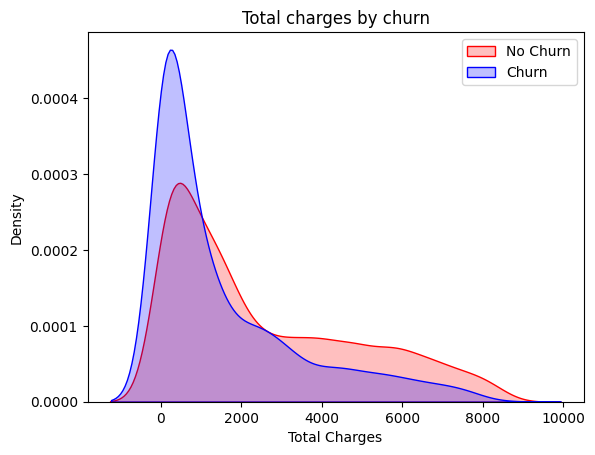

In [37]:
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 0) ],
                color="Red", fill = True)
Tot = sns.kdeplot(telco_data_dummies.TotalCharges[(telco_data_dummies["Churn"] == 1) ],
                ax =Tot, color="Blue", fill= True)
Tot.legend(["No Churn","Churn"],loc='upper right')
Tot.set_ylabel('Density')
Tot.set_xlabel('Total Charges')
Tot.set_title('Total charges by churn')

#### Observation:

- **Churned customers** cluster at low `TotalCharges`, indicating early exits.
- **Non-churned customers** show a wider spread with higher charges, reflecting longer retention.
- Clear peak separation confirms `TotalCharges` as a strong churn indicator.
- Midrange overlap (~1000–2500) may represent a churn-risk zone.

Higher total spend generally aligns with customer loyalty.


 ### 6.4 Correlation Analysis with Target (Churn)

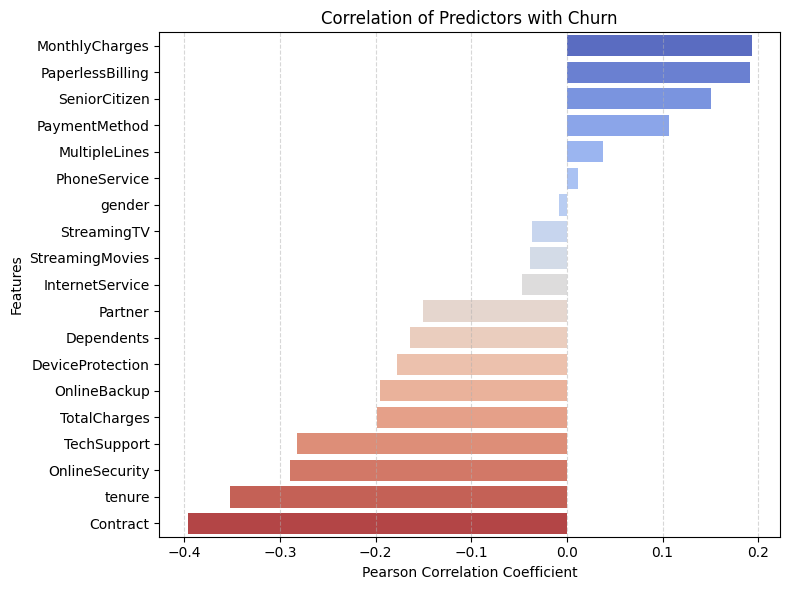

In [38]:
# Apply label encoding to all categorical columns
label_encoder = LabelEncoder()
for col in df.columns:
    if df[col].dtype == 'object':
        df[col] = label_encoder.fit_transform(df[col])

# Compute correlation of all predictors with Churn
correlation_with_churn = df.corr()['Churn'].drop('Churn').sort_values(ascending=False)

# Plot correlation with Churn
plt.figure(figsize=(8, 6))
sns.barplot(x=correlation_with_churn.values, y=correlation_with_churn.index, palette='coolwarm')
plt.title("Correlation of Predictors with Churn")
plt.xlabel("Pearson Correlation Coefficient")
plt.ylabel("Features")
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

#### Observation: Correlation Insights with Churn

- **Contract (−0.40)** and **tenure (−0.35)** show strong negative correlations: long-term plans and service duration reduce churn.
- **OnlineSecurity (−0.28)** and **TechSupport (−0.27)** lower churn likelihood, indicating retention benefit from added services.
- **TotalCharges (−0.20)** reflects loyalty; higher lifetime spenders churn less.
- **MonthlyCharges (+0.19)** and **PaperlessBilling (+0.19)** slightly increase churn, suggesting pricing and billing format sensitivity.
- **SeniorCitizen (+0.15)** and **PaymentMethod (+0.12)** have weak positive effects; older customers and e-check users churn more.
- **Gender, Partner, Dependents (~0.00)** show negligible impact and are not strong churn indicators.




## 7. Data Scaling
Scaling is important for models sensitive to feature magnitudes (e.g., Logistic Regression).

In [39]:
# Label encode categorical columns
le = LabelEncoder()
for col in df.select_dtypes(include="object").columns:
    df[col] = le.fit_transform(df[col])

In [40]:
# Apply StandardScaler only to numerical columns
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

## 8. Data Splitting

In [41]:
# Define features (X) and target (y)
X = df.drop('Churn',axis=1)
y = df['Churn']

In [42]:
# Split into training and testing sets (80-20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 9. Model Building and Evaluation (Original Data)

### 9.1 Decision Tree
- Plotted confusion matrix and printed classification report.

In [43]:
# --- Decision Tree ---
dt = DecisionTreeClassifier(criterion = "gini", max_depth=6, min_samples_leaf=8, random_state=100)
dt.fit(X_train, y_train)
y_pred_dt = dt.predict(X_test)

In [44]:
report_dt = classification_report(y_test, y_pred_dt)
print("Decision Tree - Classification Report (Original)")
print(report_dt)

Decision Tree - Classification Report (Original)
              precision    recall  f1-score   support

           0       0.86      0.87      0.86      1036
           1       0.63      0.59      0.61       373

    accuracy                           0.80      1409
   macro avg       0.74      0.73      0.74      1409
weighted avg       0.80      0.80      0.80      1409



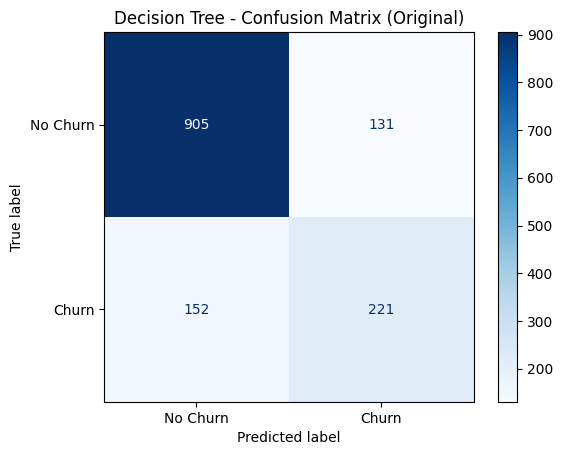

In [45]:
# Plot for Decision Tree
cm_dt = confusion_matrix(y_test, y_pred_dt)
disp_dt = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=["No Churn", "Churn"])
disp_dt.plot(cmap="Blues")
plt.title("Decision Tree - Confusion Matrix (Original)")
plt.grid(False)
plt.show()


### 9.2 Random Forest
- Visualized confusion matrix, printed metrics.

In [46]:
# --- Random Forest ---
rf = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)

In [47]:
report_rf = classification_report(y_test, y_pred_rf)
print("Random Forest - Classification Report (Original)")
print(report_rf)

Random Forest - Classification Report (Original)
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1036
           1       0.67      0.52      0.58       373

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409



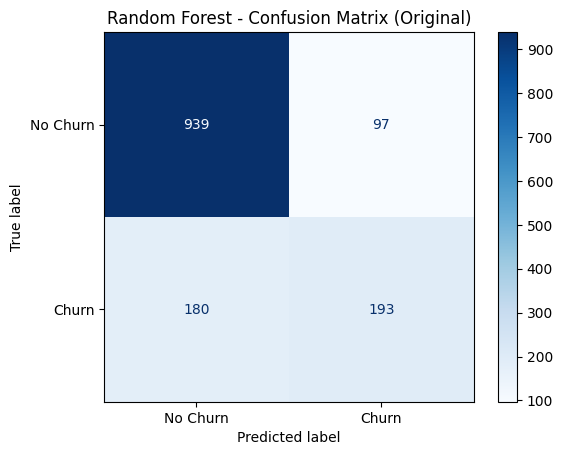

In [48]:
# Plot for Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
disp_rf = ConfusionMatrixDisplay(confusion_matrix=cm_rf, display_labels=["No Churn", "Churn"])
disp_rf.plot(cmap="Blues")
plt.title("Random Forest - Confusion Matrix (Original)")
plt.grid(False)
plt.show()

### 9.3 Logistic Regression
- Visualized confusion matrix, printed metrics

In [49]:
# --- Logistic Regression on Original Data ---
lr = LogisticRegression(solver='liblinear', random_state=42)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

In [50]:
# Report  
report_lr = classification_report(y_test, y_pred_lr)
print("Logistic Regression - Classification Report (Original)")
print(report_lr)

Logistic Regression - Classification Report (Original)
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1036
           1       0.68      0.58      0.63       373

    accuracy                           0.82      1409
   macro avg       0.77      0.74      0.75      1409
weighted avg       0.81      0.82      0.81      1409



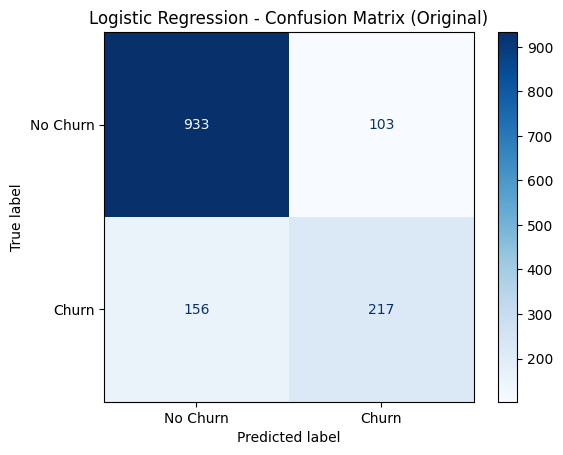

In [51]:
# confusion matrix
cm_lr = confusion_matrix(y_test, y_pred_lr)
disp_lr = ConfusionMatrixDisplay(confusion_matrix=cm_lr, display_labels=["No Churn", "Churn"])
disp_lr.plot(cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix (Original)")
plt.grid(False)
plt.show()

#### Observation: Model Performance on Imbalanced Data

The models trained on the original imbalanced dataset demonstrate acceptable overall accuracy. However, this metric is not appropriate for assessing performance in this context, as the churn class (`Churn = 1`) constitutes only a small portion of the data (~27%).

The classification reports reveal that **precision, recall, and F1-score for the minority class are considerably low**, particularly for churn prediction. This highlights the model’s bias toward the majority class, leading to poor generalization for identifying churned customers.

Given this limitation, performance metrics specific to the minority class must be prioritized. To mitigate this class imbalance and enhance model sensitivity to churned instances, a **hybrid resampling technique, SMOTEENN (Synthetic Minority Oversampling + Edited Nearest Neighbors), is applied next**.


## 10. Model Metrics Extraction  (Original Data)

- Extracted Accuracy, Precision, Recall, and F1-score for each classifier.
- Stored results for final comparison.

In [52]:
# Save performance for comparison
def extract_metrics(name, y_true, y_pred):
    r = classification_report(y_true, y_pred, output_dict=True)
    return {
        "Model": name,
        "Accuracy": r["accuracy"],
        "Precision (1)": r["1"]["precision"],
        "Recall (1)": r["1"]["recall"],
        "F1-Score (1)": r["1"]["f1-score"]
    }

# Without SMOTEENN
results_no_resample = [
    extract_metrics("Decision Tree (Original)", y_test, y_pred_dt),
    extract_metrics("Random Forest (Original)", y_test, y_pred_rf),
    extract_metrics("Logistic Regression (Original)", y_test, y_pred_lr)
]


## 11. Handling Class Imbalance with SMOTEENN

- Applied `SMOTEENN` to balance the dataset.
- Re-split resampled data into training and test sets using stratified sampling.

In [53]:
# Apply SMOTEENN
sm = SMOTEENN(random_state=42)
X_resampled, y_resampled = sm.fit_resample(X, y)
Xr_train, Xr_test, yr_train, yr_test = train_test_split(X_resampled, y_resampled, test_size=0.2, stratify=y_resampled, random_state=42)

 **Why SMOTEENN?**

Combines SMOTE (upsampling minority class) with ENN (cleaning noisy samples from majority), improving class separation.

---

## 12. Model Building and Evaluation (Resampled Data)

### 12.1 Decision Tree (SMOTEENN)

In [54]:
# Decision Tree (resampled)
dt_r = DecisionTreeClassifier(criterion = "gini", max_depth=6, min_samples_leaf=8, random_state=100)
dt_r.fit(Xr_train, yr_train)
yr_pred_dt = dt_r.predict(Xr_test)

In [55]:
report_dt_r = classification_report(yr_test, yr_pred_dt)
print("Decision Tree - Classification Report (SMOTEENN)")
print(report_dt_r)

Decision Tree - Classification Report (SMOTEENN)
              precision    recall  f1-score   support

           0       0.95      0.85      0.90       562
           1       0.89      0.97      0.93       717

    accuracy                           0.92      1279
   macro avg       0.92      0.91      0.91      1279
weighted avg       0.92      0.92      0.91      1279



**Decision Tree (SMOTEENN) – Overfitting Check**

In [56]:
# Evaluate Decision Tree model on SMOTEENN data
train_score_dt_r = dt_r.score(Xr_train, yr_train)
test_score_dt_r = dt_r.score(Xr_test, yr_test)

print("Decision Tree (SMOTEENN)")
print(f"Training Accuracy: {train_score_dt_r:.4f}")
print(f"Testing Accuracy:  {test_score_dt_r:.4f}")


Decision Tree (SMOTEENN)
Training Accuracy: 0.9363
Testing Accuracy:  0.9156


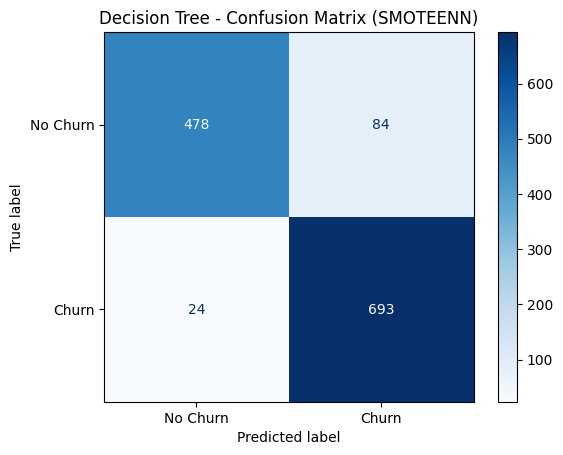

In [57]:
cm_dt_r = confusion_matrix(yr_test, yr_pred_dt)
disp_dt_r = ConfusionMatrixDisplay(confusion_matrix=cm_dt_r, display_labels=["No Churn", "Churn"])
disp_dt_r.plot(cmap="Blues")
plt.title("Decision Tree - Confusion Matrix (SMOTEENN)")
plt.grid(False)
plt.show()

Decision Tree - Feature Importance (SMOTEENN)

In [58]:
# Decision Tree Feature Importance (SMOTEENN)
importances_dt = dt_r.feature_importances_
indices_dt = np.argsort(importances_dt)[::-1]
top_features_dt = X.columns[indices_dt][:15]
top_importances_dt = importances_dt[indices_dt][:15]

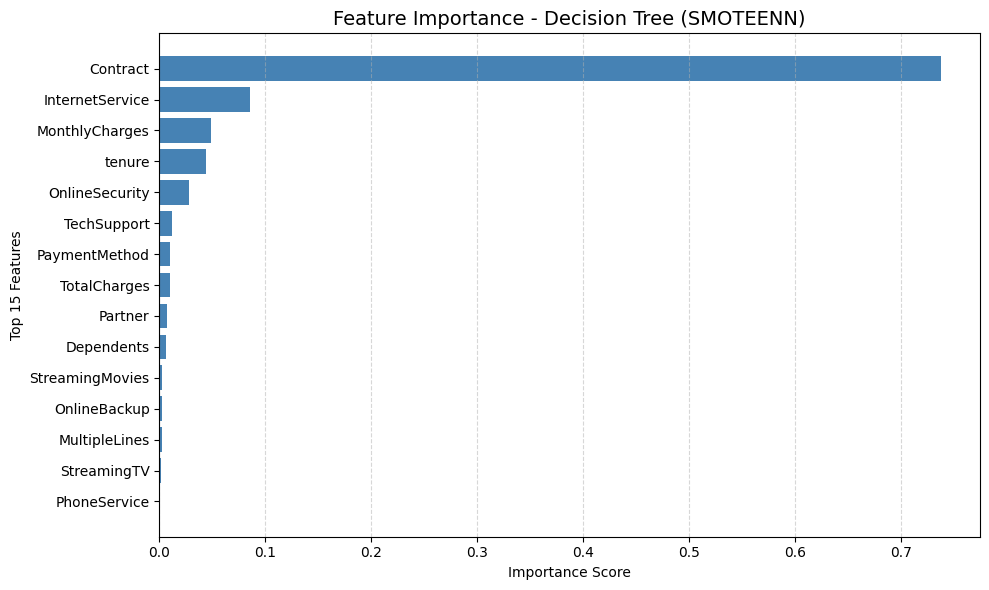

In [59]:
plt.figure(figsize=(10, 6))
plt.title('Feature Importance - Decision Tree (SMOTEENN)', fontsize=14)
plt.barh(top_features_dt[::-1], top_importances_dt[::-1], color='steelblue')
plt.xlabel('Importance Score')
plt.ylabel('Top 15 Features')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Observation: Decision Tree Feature Importance

The Decision Tree model shows `Contract` as the most critical predictor, contributing over 70% of total feature importance. `InternetService`, `MonthlyCharges`, and `tenure` follow but at much lower importance levels. Most other features, including support-related services, have minimal influence, indicating a strong reliance on contract-related patterns to predict churn.


In [60]:
# Decision Tree - Actual vs Predicted (SMOTEENN)
df_actual_pred_dt_r = pd.DataFrame({
    "Actual": yr_test,
    "Predicted": yr_pred_dt
})
df_actual_pred_dt_r.head()

,Actual,Predicted
4438,1,1
5485,1,1
2999,1,1
2041,0,0
3329,1,1


### 12.2 Random Forest (SMOTEENN)

In [61]:
# Random Forest (resampled)
rf_r = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_r.fit(Xr_train, yr_train)
yr_pred_rf = rf_r.predict(Xr_test)

In [62]:
report_rf_r = classification_report(yr_test, yr_pred_rf)
print("Random Forest - Classification Report (SMOTEENN)")
print(report_rf_r)

Random Forest - Classification Report (SMOTEENN)
              precision    recall  f1-score   support

           0       0.97      0.91      0.94       562
           1       0.94      0.98      0.96       717

    accuracy                           0.95      1279
   macro avg       0.95      0.95      0.95      1279
weighted avg       0.95      0.95      0.95      1279



**Random Forest (SMOTEENN) – Overfitting Check**

In [63]:
# Evaluate Random Forest model trained on SMOTEENN-resampled data for overfitting

# Training accuracy
train_score_rf_r = rf_r.score(Xr_train, yr_train)

# Testing accuracy (already evaluated but recomputing for clarity)
test_score_rf_r = rf_r.score(Xr_test, yr_test)

# Return results
print("Random Forest (SMOTEENN)")
print(f"Training Accuracy: {train_score_rf_r:.4f}")
print(f"Testing Accuracy:  {test_score_rf_r:.4f}")


Random Forest (SMOTEENN)
Training Accuracy: 0.9879
Testing Accuracy:  0.9492


This model can be considered best fit for the current dataset under SMOTEENN resampling. It shows strong generalization, high recall, and minimal overfitting.

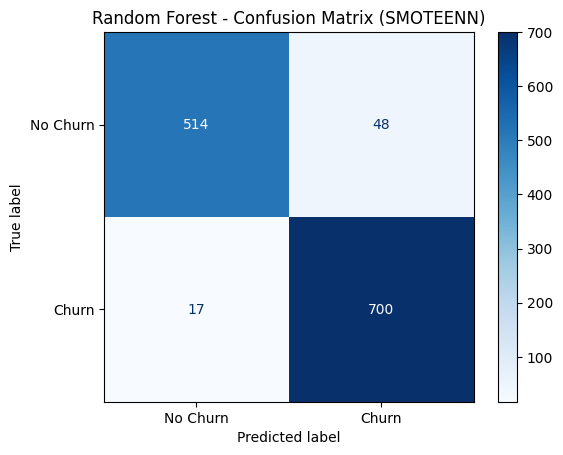

In [64]:
cm_rf_r = confusion_matrix(yr_test, yr_pred_rf)
disp_rf_r = ConfusionMatrixDisplay(confusion_matrix=cm_rf_r, display_labels=["No Churn", "Churn"])
disp_rf_r.plot(cmap="Blues")
plt.title("Random Forest - Confusion Matrix (SMOTEENN)")
plt.grid(False)
plt.show()


Random Forest - Feature Importance (SMOTEENN)

In [65]:
# Random Forest Feature Importance (SMOTEENN)
importances_rf = rf_r.feature_importances_
indices_rf = np.argsort(importances_rf)[::-1]
top_features_rf = X.columns[indices_rf][:15]
top_importances_rf = importances_rf[indices_rf][:15]



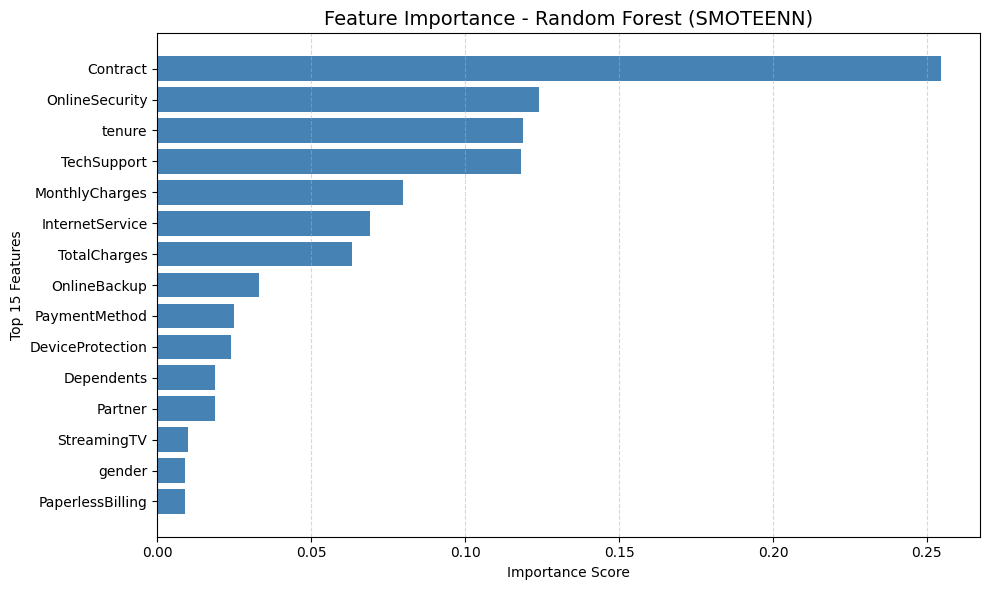

In [66]:
plt.figure(figsize=(10, 6))
plt.title('Feature Importance - Random Forest (SMOTEENN)', fontsize=14)
plt.barh(top_features_rf[::-1], top_importances_rf[::-1], color='steelblue')
plt.xlabel('Importance Score')
plt.ylabel('Top 15 Features')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Observation: Random Forest Feature Importance

Random Forest distributes importance more evenly across features. `Contract`, `OnlineSecurity`, `tenure`, and `TechSupport` are top predictors, suggesting the model leverages both billing and support-related factors. Unlike the Decision Tree, more features contribute meaningfully, reflecting the ensemble's ability to capture varied patterns.


In [67]:
# Random Forest - Actual vs Predicted (SMOTEENN)
df_actual_pred_rf_r = pd.DataFrame({
    "Actual": yr_test,
    "Predicted": yr_pred_rf
})
df_actual_pred_rf_r.head()


,Actual,Predicted
4438,1,1
5485,1,1
2999,1,1
2041,0,0
3329,1,1


### 12.3 Logistic Regression (SMOTEENN)

In [68]:
# --- Logistic Regression on SMOTEENN Data ---
lr_r = LogisticRegression(solver='liblinear', random_state=42)
lr_r.fit(Xr_train, yr_train)
yr_pred_lr = lr_r.predict(Xr_test)

In [69]:
# Report 
report_lr_r = classification_report(yr_test, yr_pred_lr)
print("Logistic Regression - Classification Report (SMOTEENN)")
print(report_lr_r)

Logistic Regression - Classification Report (SMOTEENN)
              precision    recall  f1-score   support

           0       0.92      0.88      0.90       562
           1       0.91      0.94      0.92       717

    accuracy                           0.91      1279
   macro avg       0.91      0.91      0.91      1279
weighted avg       0.91      0.91      0.91      1279



**Logistic Regression (SMOTEENN) – Overfitting Check**

In [70]:
# Evaluate Logistic Regression model on SMOTEENN data
train_score_lr_r = lr_r.score(Xr_train, yr_train)
test_score_lr_r = lr_r.score(Xr_test, yr_test)

print("Logistic Regression (SMOTEENN)")
print(f"Training Accuracy: {train_score_lr_r:.4f}")
print(f"Testing Accuracy:  {test_score_lr_r:.4f}")


Logistic Regression (SMOTEENN)
Training Accuracy: 0.9210
Testing Accuracy:  0.9132


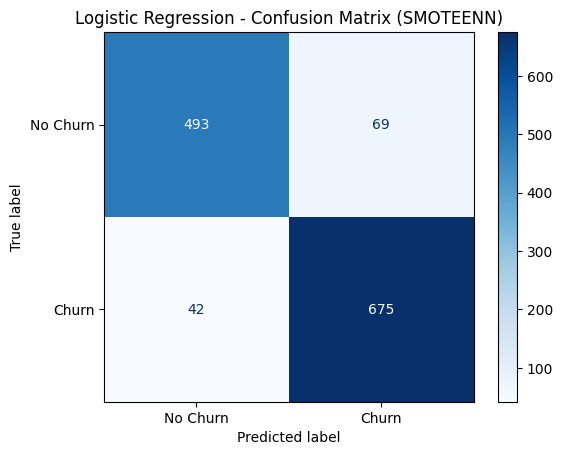

In [71]:
# confusion matrix
cm_lr_r = confusion_matrix(yr_test, yr_pred_lr)
disp_lr_r = ConfusionMatrixDisplay(confusion_matrix=cm_lr_r, display_labels=["No Churn", "Churn"])
disp_lr_r.plot(cmap="Blues")
plt.title("Logistic Regression - Confusion Matrix (SMOTEENN)")
plt.grid(False)
plt.show()

Logistic Regression - Feature Importance (SMOTEENN)

In [72]:
# Logistic Regression Feature Importance via Coefficients (SMOTEENN)
coefficients_lr = np.abs(lr_r.coef_[0])
indices_lr = np.argsort(coefficients_lr)[::-1]
top_features_lr = X.columns[indices_lr][:15]
top_coeffs_lr = coefficients_lr[indices_lr][:15]


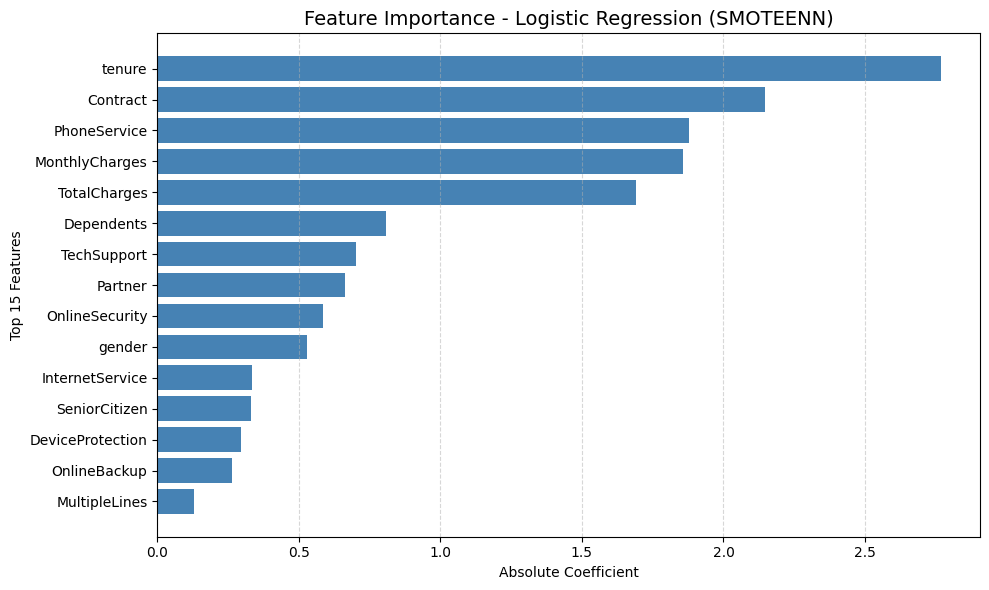

In [73]:
plt.figure(figsize=(10, 6))
plt.title('Feature Importance - Logistic Regression (SMOTEENN)', fontsize=14)
plt.barh(top_features_lr[::-1], top_coeffs_lr[::-1], color='steelblue')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Top 15 Features')
plt.grid(axis='x', linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


#### Observation: Logistic Regression Feature Importance

Logistic Regression identifies `tenure`, `Contract`, and `MonthlyCharges` as key features with the highest coefficient magnitudes. It also assigns moderate weights to support services and demographic features. The model highlights linear associations between service length, billing, and churn likelihood.


In [74]:
# Logistic Regression - Actual vs Predicted (SMOTEENN)
df_actual_pred_lr_r = pd.DataFrame({
    "Actual": yr_test,
    "Predicted": yr_pred_lr
})
df_actual_pred_lr_r.head()

,Actual,Predicted
4438,1,1
5485,1,1
2999,1,1
2041,0,0
3329,1,1


## 13. Collect Metrics from Resampled Models

- Extracted and stored performance scores for all models on resampled data.

In [75]:
# # Save performance  for comparison With SMOTEENN
results_resampled = [
    extract_metrics("Decision Tree (SMOTEENN)", yr_test, yr_pred_dt),
    extract_metrics("Random Forest (SMOTEENN)", yr_test, yr_pred_rf),
    extract_metrics("Logistic Regression (SMOTEENN)", yr_test, yr_pred_lr)
]


## 14. Final Performance Comparison

- Combined all results (before and after SMOTEENN) into a single DataFrame.
- Plotted a horizontal bar chart for:
  - Accuracy
  - Precision (churn class)
  - Recall (churn class)
  - F1-score (churn class)

In [76]:
# Final comparison
all_results = results_no_resample + results_resampled
comparison_df = pd.DataFrame(all_results)
comparison_df.set_index("Model", inplace=True)

In [77]:
comparison_df

,Accuracy,Precision (1),Recall (1),F1-Score (1)
Model,,,,
Decision Tree (Original),0.799148,0.627841,0.592493,0.609655
Random Forest (Original),0.803407,0.665517,0.517426,0.582202
Logistic Regression (Original),0.816182,0.678125,0.581769,0.626263
Decision Tree (SMOTEENN),0.915559,0.891892,0.966527,0.927711
Random Forest (SMOTEENN),0.949179,0.935829,0.976290,0.955631
Logistic Regression (SMOTEENN),0.913213,0.907258,0.941423,0.924025


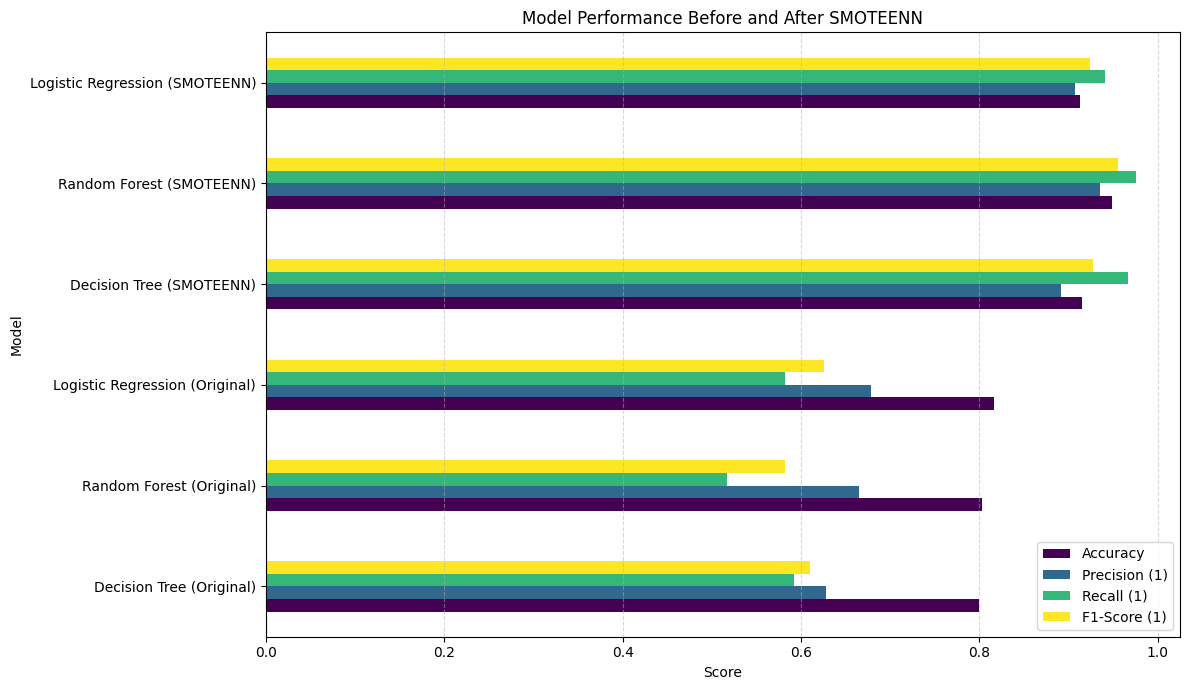

In [78]:
# Plot comparison
comparison_df.plot(kind="barh", figsize=(12, 7), colormap="viridis")
plt.title("Model Performance Before and After SMOTEENN")
plt.xlabel("Score")
plt.tight_layout()
plt.grid(True, axis="x", linestyle="--", alpha=0.5)
plt.show()

#### Observation:
The bar chart demonstrates a significant improvement in model performance metrics after applying SMOTEENN. All models show enhanced **recall** and **F1-score** for the minority class (`Churn = 1`), with minimal compromise to overall accuracy.

Among all, **Random Forest (SMOTEENN)** achieved the highest balance across all metrics, including recall and F1-score, indicating strong generalization. Logistic Regression and Decision Tree models also benefit considerably, particularly in minority class recall.

Thus, Random Forest trained on resampled data is recommended as the final model.


# Conclusion
The results indicate that models trained on the original dataset performed poorly in detecting churned customers due to the significant class imbalance. Precision, recall, and F1-score for the churn class were especially low, despite relatively high overall accuracy. 

Application of SMOTEENN significantly improved model performance, particularly in the minority class. Among all models evaluated, **Random Forest trained on SMOTEENN-resampled data demonstrated the best trade-off between recall and overall accuracy**, making it the most suitable for churn prediction in this context. Logistic Regression also offered interpretable results with competitive performance, supporting its utility in operational settings.

In summary, addressing class imbalance through hybrid resampling techniques is critical for improving predictive accuracy in churn modeling. The insights and methodology presented here may guide similar churn prediction efforts in real-world telecommunications datasets.
